## Goes over modeling, starting from modeling tables.
### We're using modeling tables which were prepared based on 12 hours worth of vital sign data from each patient, as well as medication history during the stay, and patient characteristics.
### The model predicts the probability of having a rapid response team event in 1 hour's time from the time of prediction. A RRT event is called after personnel identify that a patient has an urgent need for medical service.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# import datetime as datetime
import cPickle as pickle
%matplotlib notebook
plt.style.use('ggplot')

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier #, RandomForestClassifier, 
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.grid_search import GridSearchCV

### function definitions

In [68]:
def score_printout(X_test, y_test, fittedModel):
    print "AUC-ROC Score of model: ", roc_auc_score(y_test, fittedModel.predict_proba(X_test)[:,1])
    print "Precision Score of model: ", precision_score(y_test, fittedModel.predict(X_test))
    print "Recall Score of model: ", recall_score(y_test, fittedModel.predict(X_test))

In [118]:
def make_feature_importance_plot(featuresAndImportances, numFeatures):
    topN = featuresAndImportances[:numFeatures]
    labels = [pair[0] for pair in topN]
    values = [pair[1] for pair in topN]
    ind = np.arange(len(values)+2)
    width = 0.35   
    plt.barh(range(numFeatures),values)
    ax = plt.subplot(111)
    ax.set_yticks(ind+width)
    ax.set_yticklabels(labels, rotation=0, size=12)
    plt.ylabel('Feature', size=20)
    plt.xlabel('Importance', size=20)
    plt.show()
        
# vertical bar chart:    
#     topN = featuresAndImportances[:numFeatures]
#     labels = [pair[0] for pair in topN]
#     values = [pair[1] for pair in topN]
#     ind = np.arange(len(values))
#     width = 0.35   
#     plt.bar(range(numFeatures), values, width=0.8)
#     ax = plt.subplot(111)
#     ax.set_xticks(ind+width)
#     ax.set_xticklabels(labels, rotation=60, size=12)
#     plt.xlabel('Feature', size=20)
#     plt.ylabel('Importance', size=20)
#     plt.show()

### read in data

In [70]:
# for RRT events
masterdf_rrt = pickle.load(open('RRT_modeling_table_13hr_raw.p', 'rb'))
# for non-rrt events
masterdf_nonrrt = pickle.load(open('NonRRT_modeling_table_13hr_raw.p', 'rb'))

### Look at summary statistics for numeric columns for rrt & non-rrt tables (35 cols)

In [71]:
masterdf_rrt.columns

Index([u'rrt_ce_id', u'encntr_id', u'event_end_dt_tm', u'timestart',
       u'timeend', u'age', u'sex', u'obese', u'smoker', u'prev_rrt', u'on_iv',
       u'bu-nal', u'DBP_mean', u'DBP_recent', u'SBP_mean', u'SBP_recent',
       u'HR_mean', u'HR_recent', u'MAP_mean', u'MAP_recent', u'temp_mean',
       u'temp_recent', u'SPO2_mean', u'SPO2_recent', u'RR_mean', u'RR_recent',
       u'pulse_mean', u'pulse_recent', u'CO2_mean', u'CO2_recent', u'GCS_mean',
       u'GCS_recent', u'anticoagulants', u'narcotics', u'narc-ans',
       u'antipsychotics', u'chemo', u'dialysis', u'race', u'rrt_reason'],
      dtype='object')

In [72]:
masterdf_rrt.describe().T

,count,mean,std,min,25%,50%,75%,max
event_end_dt_tm,2063.0,1.445053e+12,1.478512e+10,1.410347e+12,1.431889e+12,1.445573e+12,1.457776e+12,1.471205e+12
timestart,2063.0,1.445006e+12,1.478512e+10,1.410300e+12,1.431842e+12,1.445526e+12,1.457729e+12,1.471158e+12
timeend,2063.0,1.445050e+12,1.478512e+10,1.410343e+12,1.431885e+12,1.445570e+12,1.457772e+12,1.471201e+12
age,2063.0,6.741154e+01,1.660477e+01,1.800000e+01,5.800000e+01,6.900000e+01,8.000000e+01,1.010000e+02
obese,1521.0,2.971729e-01,4.571636e-01,0.000000e+00,NaN,NaN,NaN,1.000000e+00
smoker,2063.0,1.051866e-01,3.068681e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
prev_rrt,2063.0,1.536597e-01,3.607097e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
on_iv,2063.0,7.280659e-01,4.450640e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
bu-nal,2063.0,3.005332e-02,1.707755e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
DBP_mean,1950.0,7.063889e+01,1.165375e+01,3.791667e+01,NaN,NaN,NaN,1.223125e+02


In [73]:
masterdf_nonrrt.describe().T

,count,mean,std,min,25%,50%,75%,max
not_rrt_time,2700.0,1.444968e+12,2.154666e+09,1.441511e+12,1.443282e+12,1.444889e+12,1.446292e+12,1.458299e+12
timestart,2700.0,1.444921e+12,2.154666e+09,1.441464e+12,1.443235e+12,1.444842e+12,1.446245e+12,1.458253e+12
timeend,2700.0,1.444964e+12,2.154666e+09,1.441508e+12,1.443279e+12,1.444885e+12,1.446289e+12,1.458296e+12
age,2700.0,6.290037e+01,1.837950e+01,1.400000e+01,5.100000e+01,6.400000e+01,7.700000e+01,1.050000e+02
obese,1886.0,3.409332e-01,4.741487e-01,0.000000e+00,NaN,NaN,NaN,1.000000e+00
smoker,2700.0,1.137037e-01,3.175099e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
prev_rrt,2700.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
on_iv,2700.0,7.611111e-01,4.264837e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
bu-nal,2700.0,6.296296e-03,7.911366e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
DBP_mean,2582.0,7.194777e+01,9.399474e+00,3.495238e+01,NaN,NaN,NaN,1.050000e+02


### We have a good amount of nan values in some columns. Lets plot the nan values to get a sense of how many there are

In [74]:
def show_df_nans(masterdf, collist=None):
    '''
    Create a data frame for features which may be nan.
    Make nan values be 1, numeric values be 0
    Dark squares/lines show where data is missing.
    '''
    if not collist:
        plot_cols = ['obese','DBP_mean', 'DBP_recent', 'SBP_mean', 'SBP_recent', 'HR_mean', 'HR_recent',
               'MAP_mean', 'MAP_recent', 'temp_mean', 'temp_recent', 'SPO2_mean',
               'SPO2_recent', 'RR_mean', 'RR_recent', 'pulse_mean', 'pulse_recent',
               'CO2_mean', 'CO2_recent', 'GCS_mean', 'GCS_recent']
    else:
        plot_cols = collist 
    
    df_viznan = pd.DataFrame(data = 1,index=masterdf.index,columns=plot_cols)
    df_viznan[~pd.isnull(masterdf[plot_cols])] = 0
    plt.figure(figsize=(10,8))
    plt.title('Dark values are nans')
    return sns.heatmap(df_viznan.astype(float))

In [75]:
# subset of numeric columns we'll use in modeling (sufficient data available)
plot_cols_good = ['obese','DBP_mean', 'DBP_recent', 'SBP_mean', 'SBP_recent', 
               'MAP_mean', 'MAP_recent', 'temp_mean', 'temp_recent', 'SPO2_mean',
               'SPO2_recent', 'RR_mean', 'RR_recent', 'pulse_mean', 'pulse_recent']

<IPython.core.display.Javascript object>


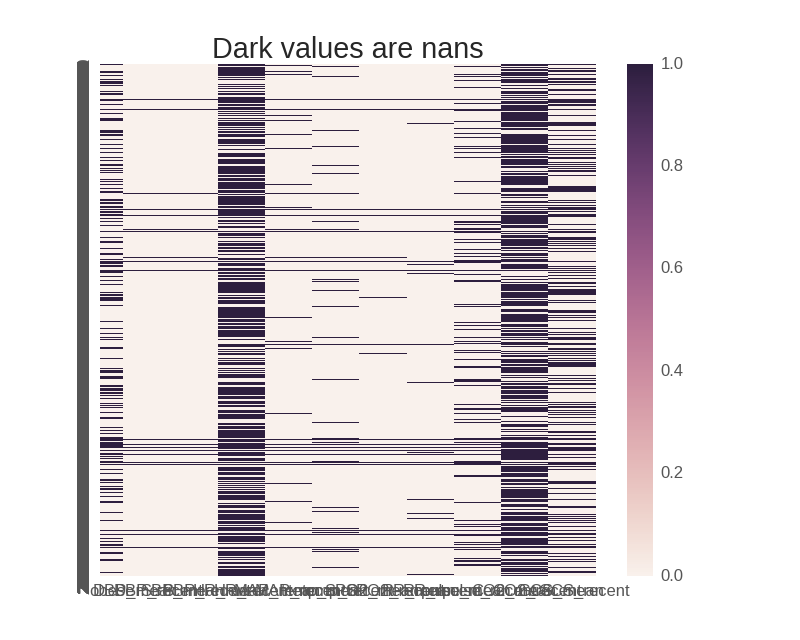

In [76]:
show_df_nans(masterdf_nonrrt)  # show all columns that may have nans
# show_df_nans(masterdf_nonrrt, plot_cols_good)  # show the columns whch we plan to use for modeling

<IPython.core.display.Javascript object>


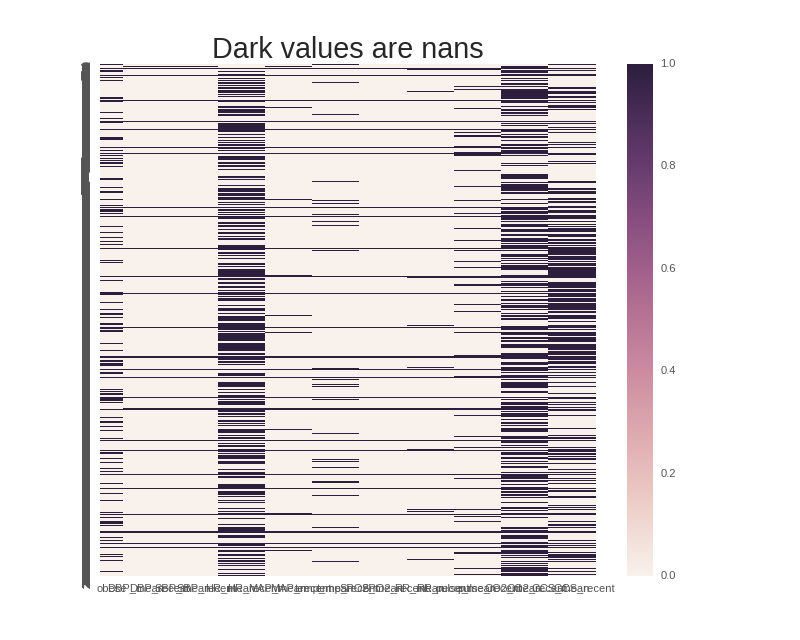

In [12]:
show_df_nans(masterdf_rrt)
# show_df_nans(masterdf_rrt, plot_cols_good)

### Let's not use those columns where there are significant nans: drop HR (heart rate; we have pulse rate instead), CO2, and GCS, which leaves us with 28 features.

In [77]:
col_use = ['age', 'sex', 'obese', 'smoker', 'prev_rrt', 'on_iv', 'bu-nal', 'DBP_mean',
       'DBP_recent', 'SBP_mean', 'SBP_recent',
       'MAP_mean', 'MAP_recent', 'temp_mean', 'temp_recent', 'SPO2_mean',
       'SPO2_recent', 'RR_mean', 'RR_recent', 'pulse_mean', 'pulse_recent',
       'anticoagulants', 'narcotics', 'narc-ans', 'antipsychotics',
       'chemo', 'dialysis', 'race']

In [78]:
X_rrt = masterdf_rrt[col_use]
X_notrrt = masterdf_nonrrt[col_use]

### We need to deal with these nans before we can start modeling. (There should not be any nans in the modeling table)

In [79]:
# let's look at getting rid of the data rows where vitals signs are all nans
vitals_cols = ['DBP_mean', 'DBP_recent', # take the mean of all the measurements & the most recently observed point
            'SBP_mean', 'SBP_recent',
            'MAP_mean', 'MAP_recent', # mean arterial pressure
             'temp_mean', 'temp_recent',# temperature
             'SPO2_mean', 'SPO2_recent',
            'RR_mean', 'RR_recent', # respiratory rate
            'pulse_mean', 'pulse_recent']

In [80]:
# Write out rows that are not all 0/NaNs across. (if all nans, remove this sample)
X_rrt = X_rrt.loc[np.where(X_rrt.ix[:, vitals_cols].sum(axis=1, skipna=True)!=0)[0]]
X_rrt = X_rrt.reset_index(drop=True)
X_notrrt = X_notrrt.loc[np.where(X_notrrt.ix[:, vitals_cols].sum(axis=1, skipna=True)!=0)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)

In [81]:
# if 'obese' is Nan, then set the patient to be not obese.
X_rrt.loc[np.where(pd.isnull(X_rrt['obese']))[0], 'obese'] = 0
X_notrrt.loc[np.where(pd.isnull(X_notrrt['obese']))[0], 'obese'] = 0

### Let's see how X_rrt & X_notrrt look

<IPython.core.display.Javascript object>


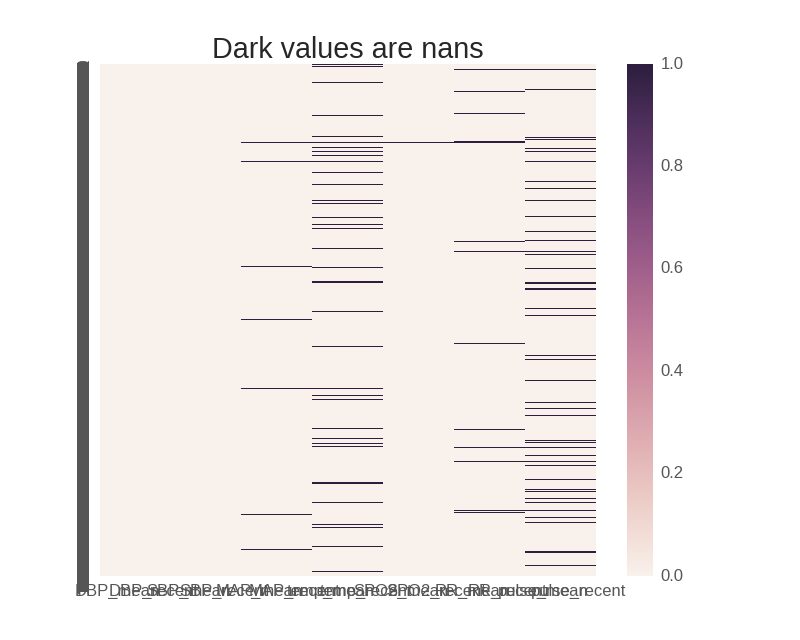

In [82]:
show_df_nans(X_rrt, vitals_cols)

<IPython.core.display.Javascript object>


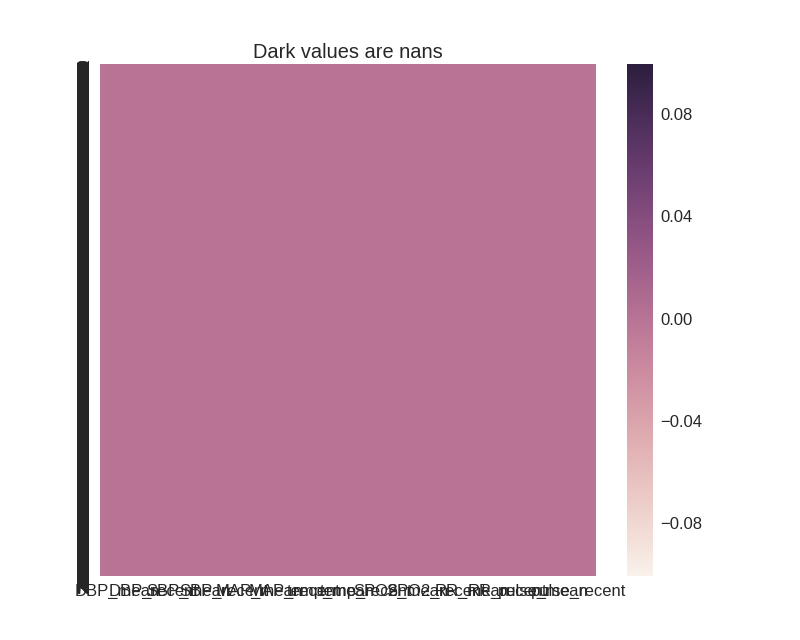

In [121]:
show_df_nans(X_notrrt, vitals_cols)

    ### MAP, temp, RR, and pulse have significant missing values, particularly pulse.

In [84]:
print X_rrt[['pulse_mean', 'pulse_recent']].describe().T
print "size of X_rrt: "+str(len(X_rrt))
print
print X_notrrt[['pulse_mean', 'pulse_recent']].describe().T
print "size of X_notrrt: " + str(len(X_notrrt))

               count       mean        std   min  25%  50%  75%    max
pulse_mean    1795.0  90.145257  19.175288  36.0  NaN  NaN  NaN  161.0
pulse_recent  1795.0  91.329248  22.325309   0.0  NaN  NaN  NaN  175.0
size of X_rrt: 1955

               count       mean        std   min  25%  50%  75%    max
pulse_mean    2193.0  78.365065  14.435504  31.5  NaN  NaN  NaN  247.0
pulse_recent  2193.0  78.157775  16.583336   9.0  NaN  NaN  NaN  444.0
size of X_notrrt: 2591


#### We have (1955-1795)/1955 = 0.082  => 8% of the values for pulse are missing in RRT. --> safe to impute missing values
#### (2591 - 2193)/2591 = 0.154 => 15% of the values for pulse are missing from NonRRT.

#### We have plenty of samples for the non-RRT case. We can delete off rows with values that are missing without concern that we'll lose negtive examples for RRT events for modeling.

In [85]:
# DROP THE ROWS WHERE PULSE IS NAN
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['pulse_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
# And similarly for all rows with significant nans:
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['RR_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['MAP_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['temp_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)
X_notrrt = X_notrrt.ix[np.where(pd.isnull(X_notrrt['SPO2_mean'])!=True)[0]]
X_notrrt = X_notrrt.reset_index(drop=True)


In [86]:
all_cols = ['age', 'sex', 'obese', 'smoker', 'prev_rrt', 'on_iv', 'bu-nal',
       'DBP_mean', 'DBP_recent', 'SBP_mean', 'SBP_recent', 'MAP_mean',
       'MAP_recent', 'temp_mean', 'temp_recent', 'SPO2_mean',
       'SPO2_recent', 'RR_mean', 'RR_recent', 'pulse_mean', 'pulse_recent',
       'anticoagulants', 'narcotics', 'narc-ans', 'antipsychotics',
       'chemo', 'dialysis', 'race']

In [87]:
show_df_nans(X_notrrt, all_cols)

<IPython.core.display.Javascript object>

### Still need to deal with nans in X_rrt. Temp & pulse are the most of concern

In [88]:
X_rrt[['temp_mean', 'pulse_mean']].describe().T

,count,mean,std,min,25%,50%,75%,max
temp_mean,1820.0,36.775522,0.479658,34.75,NaN,NaN,NaN,40.1
pulse_mean,1795.0,90.145257,19.175288,36.00,NaN,NaN,NaN,161.0


### We'll impute missing values in X_rrt after combining that data with X_notrrt, and use the mean from each column after merging to fill the values.

In [89]:
# add labels to indicate positive or negative class
X_rrt['label'] = 1
X_notrrt['label'] = 0

# Combine the tables
XY = pd.concat([X_rrt, X_notrrt])
XY = XY.reset_index(drop=True)
y = XY.pop('label')
X = XY

# Fill nans with mean of columns
X = X.fillna(X.mean())

In [90]:
# map genders to 1/0
X['is_male'] = X['sex'].map({'M': 1, 'F': 0})
X.pop('sex')

0       M
1       F
2       F
3       M
4       F
5       F
6       F
7       M
8       F
9       F
10      M
11      F
12      M
13      M
14      M
15      M
16      F
17      M
18      F
19      F
20      F
21      F
22      F
23      M
24      M
25      M
26      F
27      F
28      F
29      M
       ..
3941    F
3942    F
3943    M
3944    M
3945    F
3946    M
3947    F
3948    F
3949    M
3950    M
3951    M
3952    F
3953    F
3954    F
3955    F
3956    F
3957    M
3958    F
3959    M
3960    F
3961    M
3962    M
3963    F
3964    F
3965    F
3966    M
3967    F
3968    M
3969    M
3970    F
Name: sex, dtype: object

In [91]:
X.race.value_counts()

White                                        2236
Other Race                                    991
Asian                                         392
Black or African American                     206
Declined                                       51
Unknown                                        45
Native Hawaiian or Other Pacific Islander      22
American Indian or Alaska Native               18
Not Reported                                    8
Filipino/Non-Hispanic                           1
White/Non-Hispanic                              1
Name: race, dtype: int64

In [102]:
# we won't use race in modeling
X.pop('race')

0                           White
1                           White
2                           White
3                           White
4                      Other Race
5                      Other Race
6                      Other Race
7                           White
8                           White
9                           White
10                     Other Race
11                     Other Race
12                          White
13                          White
14                          White
15                          White
16                          White
17                          Asian
18                          White
19                          White
20                          White
21                          White
22                          White
23                          White
24                          Asian
25                     Other Race
26                          White
27                          White
28                          Asian
29            

<IPython.core.display.Javascript object>


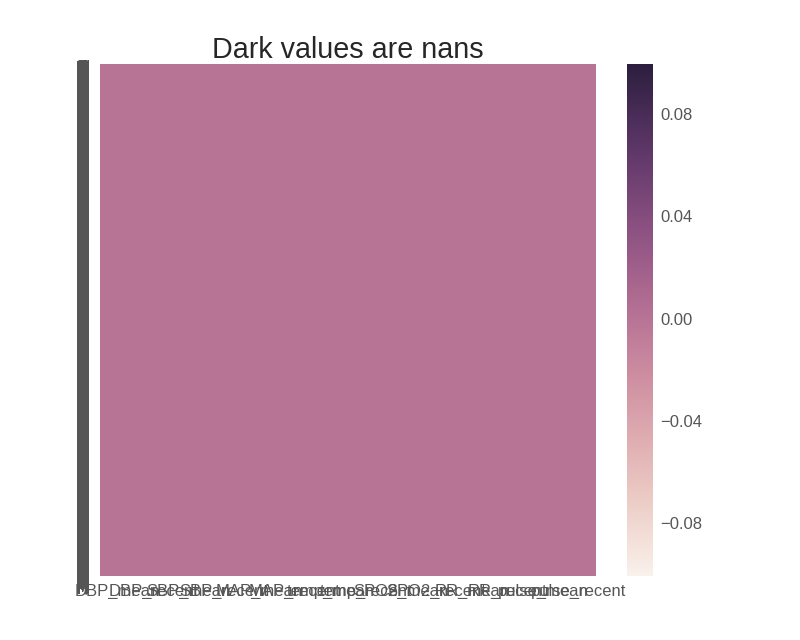

In [103]:
show_df_nans(X, vitals_cols)

In [104]:
X.columns

Index([u'age', u'obese', u'smoker', u'prev_rrt', u'on_iv', u'bu-nal',
       u'DBP_mean', u'DBP_recent', u'SBP_mean', u'SBP_recent', u'MAP_mean',
       u'MAP_recent', u'temp_mean', u'temp_recent', u'SPO2_mean',
       u'SPO2_recent', u'RR_mean', u'RR_recent', u'pulse_mean',
       u'pulse_recent', u'anticoagulants', u'narcotics', u'narc-ans',
       u'antipsychotics', u'chemo', u'dialysis', u'is_male'],
      dtype='object')

In [105]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3971.0,65.045832,17.595523,14.000000,55.000000,67.000000,78.000000,105.000000
obese,3971.0,0.240242,0.427284,0.000000,0.000000,0.000000,0.000000,1.000000
smoker,3971.0,0.111559,0.314863,0.000000,0.000000,0.000000,0.000000,1.000000
prev_rrt,3971.0,0.079577,0.270671,0.000000,0.000000,0.000000,0.000000,1.000000
on_iv,3971.0,0.771342,0.420021,0.000000,1.000000,1.000000,1.000000,1.000000
bu-nal,3971.0,0.018131,0.133444,0.000000,0.000000,0.000000,0.000000,1.000000
DBP_mean,3971.0,71.503803,10.483884,37.916667,64.125000,71.090909,78.500000,122.312500
DBP_recent,3971.0,71.540091,12.278271,9.000000,63.000000,71.000000,79.000000,147.000000
SBP_mean,3971.0,127.354561,21.216642,61.200000,112.183333,125.333333,141.645833,207.388889
SBP_recent,3971.0,126.754726,23.739414,1.000000,110.000000,125.000000,143.000000,228.000000


# Modeling

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [107]:
print len(y_train)
print len(y_train[y_train]==1)

2779
2779


In [108]:
len(y_test[y_test==1])

590

In [111]:
Xscaled = StandardScaler().fit_transform(X)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xscaled, y, test_size=0.3)

## Gradient Boosting Classifier - Scaled & unscaled (with partial dependence plots)


## Grid search for best GBC

In [37]:
# paramGrid = {'n_estimators': [100, 200, 300],
#              'learning_rate': [0.1, 0.05, 0.01, 0.2],
#              'max_depth': [3, 4, 5, 6],
#              'min_samples_leaf': [1, 2],
#              'subsample': [0.75, 1.0, 0.85],
#              'loss': ['deviance'],
#              'max_features': [None, 'auto']
#             }

# gs = GridSearchCV(GradientBoostingClassifier(), 
#                   param_grid=paramGrid, 
#                   scoring='roc_auc', 
#                   n_jobs=-1, 
#                   cv=5, 
#                   verbose=10)

# gs.fit(X_train, y_train)

# result:
# GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#               max_depth=3, max_features=None, max_leaf_nodes=None,
#               min_samples_leaf=2, min_samples_split=2,
#               min_weight_fraction_leaf=0.0, n_estimators=300,
#               presort='auto', random_state=None, subsample=0.75, verbose=0,
#               warm_start=False)

In [38]:
# paramGrid = {'n_estimators': [100, 200, 300],
#              'learning_rate': [0.1, 0.05, 0.01, 0.2],
#              'max_depth': [3, 4, 5, 6],
#              'min_samples_leaf': [1, 2],
#              'subsample': [0.75, 1.0, 0.85],
#              'loss': ['deviance'],
#              'max_features': [None, 'auto']
#             }

# gss = GridSearchCV(GradientBoostingClassifier(), 
#                   param_grid=paramGrid, 
#                   scoring='roc_auc', 
#                   n_jobs=-1, 
#                   cv=5, 
#                   verbose=10)

# gss.fit(Xs_train, ys_train)

# result:
# GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#               max_depth=3, max_features='auto', max_leaf_nodes=None,
#               min_samples_leaf=1, min_samples_split=2,
#               min_weight_fraction_leaf=0.0, n_estimators=300,
#               presort='auto', random_state=None, subsample=0.75, verbose=0,
#               warm_start=False)


## How different are best estimators for scaled & unscaled data?

In [39]:
# gs.best_estimator_

In [40]:
# gss.best_estimator_

In [112]:
gbc = GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
               max_depth=3, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=2, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=300,
               presort='auto', random_state=None, subsample=0.75, verbose=0,
               warm_start=False)
gbc.fit(X_train, y_train)
score_printout(X_test, y_test, gbc)
print classification_report(y_test, gbc.predict(X_test))
confusion_matrix(y_test, gbc.predict(X_test))

AUC-ROC Score of model:  0.84696773467
Precision Score of model:  0.798493408663
Recall Score of model:  0.718644067797
             precision    recall  f1-score   support

          0       0.75      0.82      0.78       602
          1       0.80      0.72      0.76       590

avg / total       0.77      0.77      0.77      1192



array([[495, 107],
       [166, 424]])

In [42]:
# gbcs = gss.best_estimator_
# gbcs.fit(Xs_train, ys_train)
# score_printout(Xs_test, ys_test, gbc)
# print classification_report(ys_test, gbcs.predict(Xs_test))
# confusion_matrix(ys_test, gbcs.predict(Xs_test))

### Use unscaled data -- better results & easier interpretability

<IPython.core.display.Javascript object>


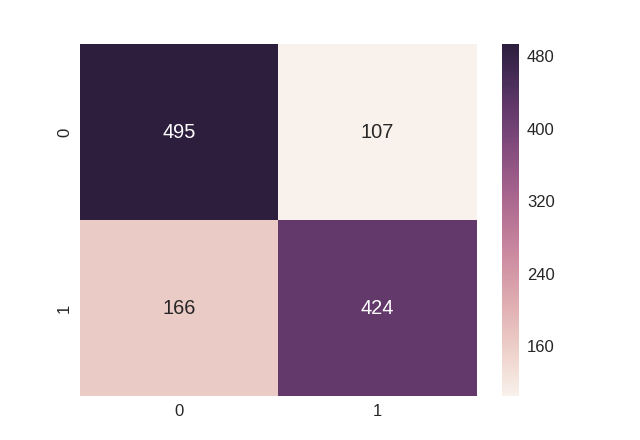

In [113]:
# Let's plot the confusion matrix so it's a little clearer
plt.figure()
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(y_test, gbc.predict(X_test)), annot=True, fmt='d')

## Discussion
#### The confusion matrix above shows that we have:
    - 524 True Negaitves - there was no RRT event, and our model predicted that.
    - 431 True Positives - there was an RRT event and our model predicted that.
    - 165 False Negatives - where there was an RRT event, but the model predicted there wouldn't be
    - 72 False Positives - there was no RRT event, but the model predicted there would be
    
#### This implies that in about 75% of cases, we successfully predict whether there will or will not be an rrt event.
#### What about the remaining quarter of the cases when we're wrong? In these cases, we more often predict there will not be an RRT event when there is one. This reflects today's operations of the RRT -- they rely on staff to alert, and the alert may only take place once a patient has deteriorated. The least common result (accounting for 6% of all cases) was a false positive -- an RRT event did not happen but we predicted it would. Although in this case, the patient is not in danger, an RRT mobilization is costly. In this case, if the score is high but the patient otherwise looks stable, the RRT might be called for a consult rather than to respond to an event.


### These results imply that patient scores based on this model could help with patient triage for 3/4 of patients, and thus prevent future RRT events from taking place.

## Let's look at the most important features in this model

In [114]:
gbcRankedFeatures = sorted(zip(X.columns, gbc.feature_importances_), 
                          key=lambda pair: pair[1], 
                          reverse=False)

<IPython.core.display.Javascript object>


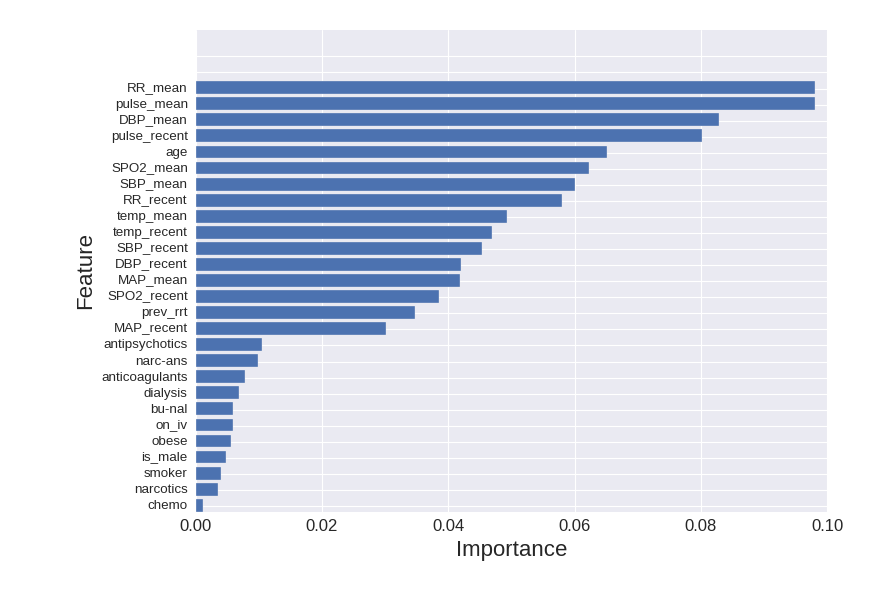

In [120]:
plt.figure(fig)
make_feature_importance_plot(gbcRankedFeatures, 27) # note - we have 27 features currently
plt.tight_layout()

### Let's look a partial dependence plots
#### If the partial dependence is high, then the model for that given value of that given feature is more likely to predict an rrt result.
#### Will not show more complex interactions -- if importance is high but partial dependence is marginal, this may be due to interactions

<IPython.core.display.Javascript object>


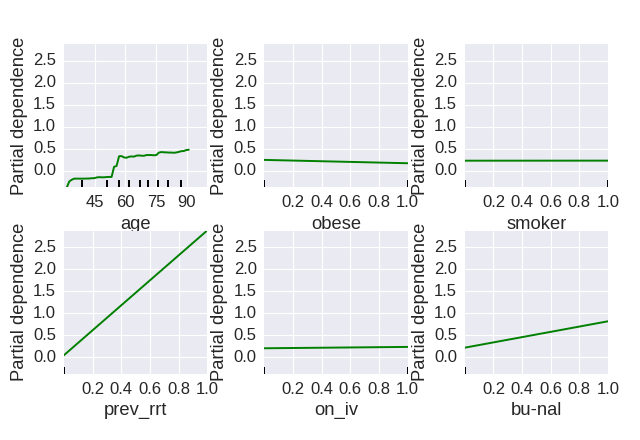

In [46]:
fig, axs = plot_partial_dependence(gbc, X_train, range(0, 6, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


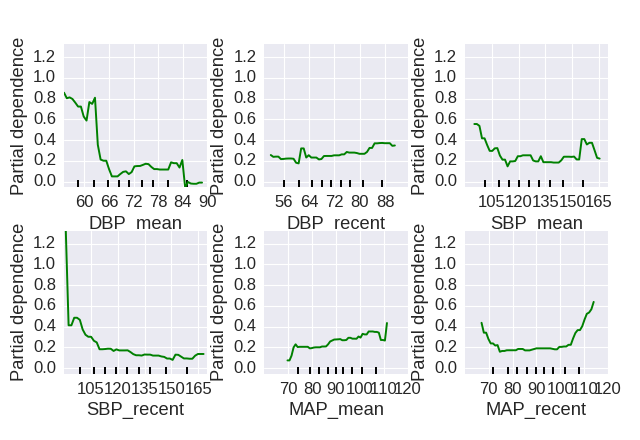

In [47]:
fig, axs = plot_partial_dependence(gbc, X_train, range(6, 12, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


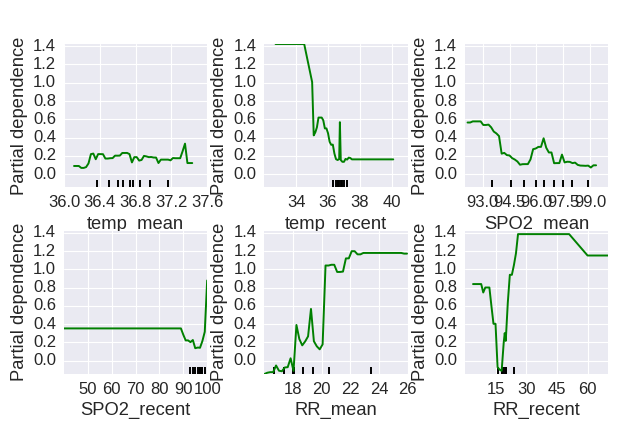

In [48]:
fig, axs = plot_partial_dependence(gbc, X_train, range(12, 18, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


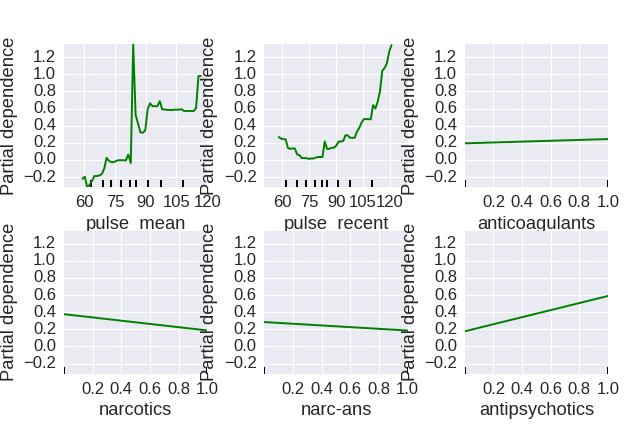

In [49]:
fig, axs = plot_partial_dependence(gbc, X_train, range(18, 24, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

<IPython.core.display.Javascript object>


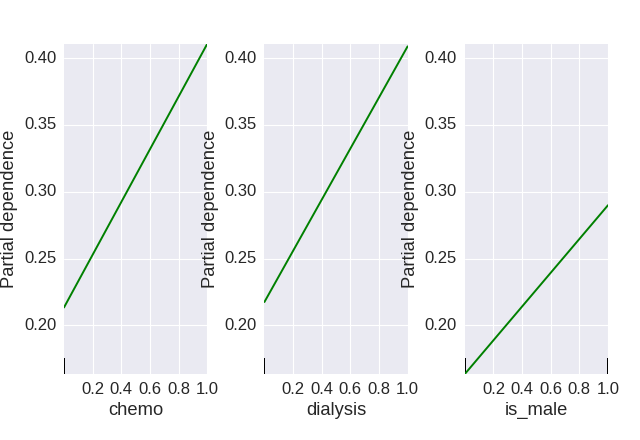

In [50]:
fig, axs = plot_partial_dependence(gbc, X_train, range(24, 27, 1), feature_names=X.columns.get_values(), n_jobs=-1, grid_resolution=50)
plt.subplots_adjust(top=0.9)

## Use 3-D plot to investigate feature interactions for weak partial dependence plots... (weak effect may be masked by stronger interaction with other features)

In [51]:
names = X_train.columns
zip(range(len(names)), names)

[(0, 'age'),
 (1, 'obese'),
 (2, 'smoker'),
 (3, 'prev_rrt'),
 (4, 'on_iv'),
 (5, 'bu-nal'),
 (6, 'DBP_mean'),
 (7, 'DBP_recent'),
 (8, 'SBP_mean'),
 (9, 'SBP_recent'),
 (10, 'MAP_mean'),
 (11, 'MAP_recent'),
 (12, 'temp_mean'),
 (13, 'temp_recent'),
 (14, 'SPO2_mean'),
 (15, 'SPO2_recent'),
 (16, 'RR_mean'),
 (17, 'RR_recent'),
 (18, 'pulse_mean'),
 (19, 'pulse_recent'),
 (20, 'anticoagulants'),
 (21, 'narcotics'),
 (22, 'narc-ans'),
 (23, 'antipsychotics'),
 (24, 'chemo'),
 (25, 'dialysis'),
 (26, 'is_male')]

In [52]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


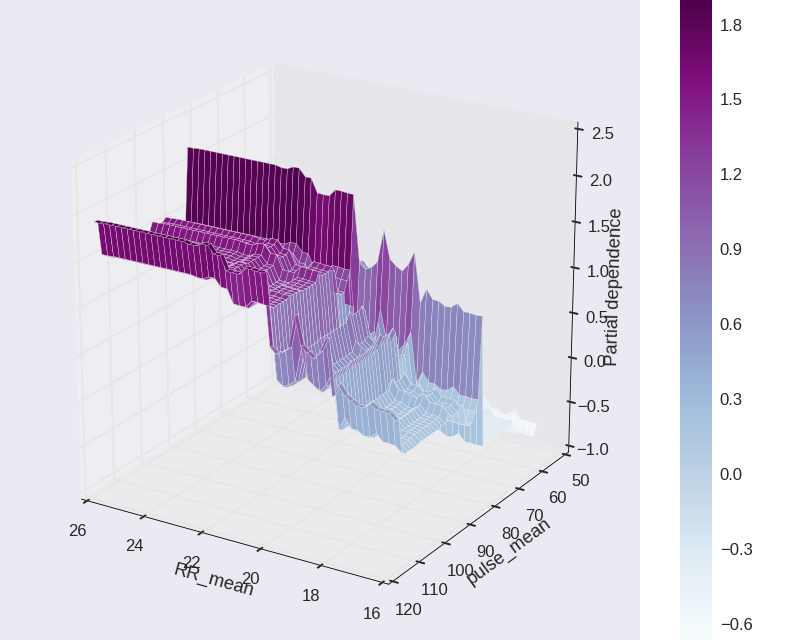

In [53]:
# not all features may work for this viz
fig = plt.figure(figsize=(10,8))
target_feature = (16, 18)  # <--  change the two numbers here to determine what to plot up
pdp, (x_axis, y_axis) = partial_dependence(gbc, target_feature, X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('')
plt.subplots_adjust(top=0.9)

plt.show()

## From Model to Risk Score


In [54]:
# Return probabilities from the model, rather than predictions
y_proba = gbc.predict_proba(X_test)

In [55]:
# note - y_proba contains probabilities for class 0 in column 0 & probabilities for class 1 in column 1.
# we're only interested in the probability for class 1
y_proba

array([[ 0.46540427,  0.53459573],
       [ 0.01238859,  0.98761141],
       [ 0.60131526,  0.39868474],
       ..., 
       [ 0.11666785,  0.88333215],
       [ 0.81656654,  0.18343346],
       [ 0.02238504,  0.97761496]])

In [56]:
pred_probs = pd.DataFrame(data=y_proba[:,1], columns =["model_probability_of_rrt"], index = X_test.index)

In [57]:
X_test.head()

,age,obese,smoker,prev_rrt,on_iv,bu-nal,DBP_mean,DBP_recent,SBP_mean,SBP_recent,...,RR_recent,pulse_mean,pulse_recent,anticoagulants,narcotics,narc-ans,antipsychotics,chemo,dialysis,is_male
3192,70,1.0,0.0,0.0,0.0,0.0,75.50,90.0,152.0,138.0,...,18.000000,100.000000,103.000000,1.0,0.0,0.0,0.0,0.0,0.0,1
1462,89,0.0,0.0,1.0,1.0,0.0,68.00,72.0,120.0,122.0,...,19.503933,83.840333,84.273944,1.0,0.0,0.0,0.0,1.0,0.0,0
1741,77,0.0,0.0,0.0,0.0,0.0,67.75,56.0,162.5,119.0,...,20.000000,73.000000,76.000000,1.0,0.0,1.0,0.0,0.0,0.0,0
1049,67,0.0,0.0,0.0,1.0,0.0,62.00,52.0,115.0,110.0,...,16.000000,88.000000,90.000000,0.0,1.0,0.0,0.0,0.0,0.0,1
994,74,0.0,1.0,0.0,1.0,0.0,82.00,83.0,117.0,118.0,...,18.000000,94.500000,78.000000,1.0,1.0,0.0,0.0,0.0,0.0,1


In [58]:
y_test.head()

3192    0
1462    1
1741    1
1049    1
994     1
Name: label, dtype: int64

In [59]:
pred_probs['model_probability_of_rrt'] = pd.to_numeric(pred_probs.model_probability_of_rrt)

<IPython.core.display.Javascript object>


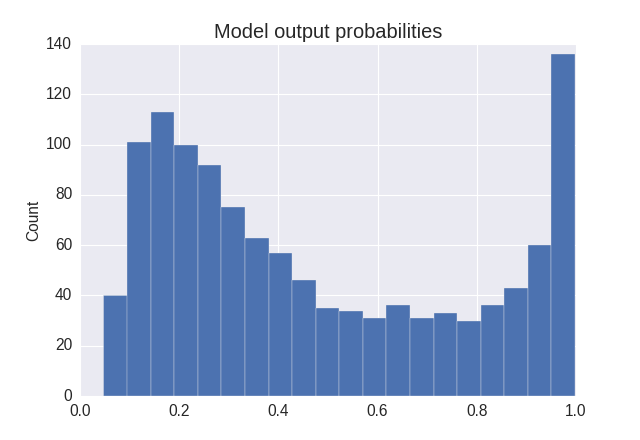

In [60]:
pred_probs.hist(bins = 20, xlabelsize = 16, ylabelsize=16)
plt.tick_params(labelsize=14)
plt.title("Model output probabilities")
plt.ylabel('Count', fontsize=14)

### We see that although we see more values close to 0 and 1, we also see that the model outputs a full range of probabilities, which would translate well into risk scores.


### Patient Risk Score = model probability * 10
The score should be rounded to whole values to give the sense that this is not an exact measure.

In [61]:
pred_probs['score'] = pred_probs['model_probability_of_rrt'].apply(lambda x: int(round(x*10.0, 0)))

In [62]:
pred_probs.head()

,model_probability_of_rrt,score
3192,0.534596,5
1462,0.987611,10
1741,0.398685,4
1049,0.413748,4
994,0.277500,3


In [63]:
pred_probs.score.value_counts()

2     214
3     175
1     160
10    136
4     113
9     106
5      80
8      70
6      69
7      68
0       1
Name: score, dtype: int64

### save out model

In [65]:
from sklearn.externals import joblib
# # joblib.dump(gbc, 'gbc_base.pkl') # note - if left uncompressed, this writes a whole lot of supporting numpy files.
joblib.dump(gbc, 'gbc_base.compressed', compress=True)  

# to unpack: joblib.load(filename)

['gbc_base.compressed']

In [424]:
gbc

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)

### save out modeling table

In [414]:
# # create combined data frame including modeling table, rrt label, and proability associated with result
df = pd.concat([X_test, pred_probs, y_test],axis=1, join_axes=[X_test.index])

In [415]:
df.head()

,age,obese,smoker,prev_rrt,on_iv,bu-nal,DBP_mean,DBP_recent,SBP_mean,SBP_recent,...,anticoagulants,narcotics,narc-ans,antipsychotics,chemo,dialysis,is_male,model_probability_of_rrt,score,label
873,75,0.0,0.0,0.0,1.0,0.0,64.666667,67.0,110.666667,104.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0,0.480600,5,1
847,76,0.0,0.0,1.0,1.0,0.0,61.714286,59.0,89.857143,89.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1,0.979395,10,1
3223,49,0.0,0.0,0.0,1.0,0.0,66.818182,74.0,103.818182,113.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0,0.147548,1,0
3916,51,1.0,0.0,0.0,1.0,0.0,88.000000,82.0,145.666667,137.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0,0.183144,2,0
1203,67,0.0,1.0,0.0,0.0,0.0,68.250000,76.0,114.000000,125.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0.508413,5,1


In [416]:
# df.to_csv('ModelingTable_with_results.csv')

In [418]:
# May need to rename columns to get rid of dash in name...
# df.rename(columns={'bu-nal': 'bu_nal', 'narc-ans': 'narc_ans'}, inplace=True)